# 1. Setup

In [ ]:
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))

In [ ]:
import json

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from optuna.samplers import TPESampler
from pandas import DataFrame, Series, Timedelta, Timestamp
from sklearn.metrics import mean_absolute_error as MAE
from xgboost import DMatrix, XGBRegressor

In [ ]:
from utils.loading import load_all_raw_data
from utils.preprocessing import process_all_dfs
from utils.merging import merge_all_dfs
from utils.feature_engineering import *

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 100)

In [ ]:
RAW_DATA_PATH = "../data/raw_data/"
ADDITIONAL_DATA_PATH = "../data/additional_data/"

SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]
RAND = 10

In [ ]:
processed_dfs = process_all_dfs(
    load_all_raw_data(RAW_DATA_PATH, ADDITIONAL_DATA_PATH)
)

# processed_dfs.keys()
df = merge_all_dfs(processed_dfs, how="left")
df = add_dst_flag(df)
df = add_cyclic_datetime_features(df, drop_raw=True)

In [ ]:
for lag in [2, 3, 7]:
# for lag in range(2, 15):
    df = df.merge(
        get_lag(processed_dfs["train"][TARGET_C + ["target"]], lag=lag),
        how="left",
        on=TARGET_C,
    )

In [ ]:
for window in [24, 24 * 3, 24 * 7, 24 * 14]:
    # for window in [24 * i for i in range(1, 15)]:
    df = df.merge(
        get_moving_average(
            processed_dfs["train"]
            .set_index("datetime")
            .sort_index()
            .groupby(CATEGORICAL_C, observed=True, as_index=False),
            columns=["target"],
            window=window,
            # ).dropna(),
        ),
        how="left",
        on=TARGET_C,
    )

In [ ]:
df["t_over_cap"] = (df["2d_lag_target"] / df["installed_capacity"]).astype(
    "float32"
)
df["t_over_eic"] = (df["2d_lag_target"] / df["eic_count"]).astype("float32")
df["cap_per_eic"] = (df["installed_capacity"] / df["eic_count"]).astype(
    "float32"
)

In [ ]:
FEATURES_TO_DROP = ["datetime", "data_block_id", "date"]

# 2. Time Splits

In [ ]:
# VAL_SPLITS = 3

In [ ]:
# train - val - test
# .64 - .16 - .20

In [ ]:
# train_dt_start = df["datetime"].min()
# val_dt_start = (
#     train_dt_start + (df["datetime"].max() - train_dt_start) * 0.64
# ).normalize()
# test_dt_start = (
#     train_dt_start + (df["datetime"].max() - train_dt_start) * 0.8
# ).normalize()

# train_dt_end = val_dt_start - Timedelta(hours=1)
# val_dt_end = test_dt_start - Timedelta(hours=1)
# test_dt_end = df["datetime"].max()

# train_range = (train_dt_end - train_dt_start).ceil('d')
# val_range = (val_dt_end -  val_dt_start).ceil('d')
# test_range = (test_dt_end - test_dt_start).ceil('d')

# print(
#     f"Train range starts: {train_dt_start}",
#     f"Train range length: {train_range.days}",
#     f"Train range ends: {train_dt_end}",
    
#     f"Validation range starts: {val_dt_start}",
#     f"Validation range length: {val_range.days}",
#     f"Validation range ends: {val_dt_end}",
    
#     f"Test range starts: {test_dt_start}",
#     f"Test range length: {test_range.days}",
#     f"Test range ends: {test_dt_end}",
#     sep="\n",
# )

Train range starts: 2021-09-01 00:00:00
Train range length: 408
Train range ends: 2022-10-13 23:00:00
Validation range starts: 2022-10-14 00:00:00
Validation range length: 102
Validation range ends: 2023-01-23 23:00:00
Test range starts: 2023-01-24 00:00:00
Test range length: 128
Test range ends: 2023-05-31 23:00:00


In [ ]:
# for i, d in enumerate(split_intervals(df['datetime'], expanding=True)[1]):
#     print(i, "train", d["train"])
#     print(i, "test", d["test"])
#     print(d["train"][1] - d["train"][0])
#     print(d["test"][1] - d["test"][0])

In [ ]:
# test = split_intervals(df['datetime'])
# print(
#     # f"All days: {test["all"]}",
#     f"Train range starts: {test['train_start']}",
#     f"Train range length: {test['train_range']}",
#     f"Train range ends: {test['train_end']}",
    
#     f"Validation range starts: {test['val_start']}",
#     f"Validation range length: {test['val_range']}",
#     f"Validation range ends: {test['val_end']}",
    
#     f"Test range starts: {test['test_start']}",
#     f"Test range length: {test['test_range']}",
#     f"Test range ends: {test['test_end']}",
#     sep="\n",
# )

In [ ]:
# splits = [
#     {
#         "train": (train_dt_start, train_dt_end),
#         "val": (val_dt_start, val_dt_start + Timedelta(days=6, hours=23)),
#     },
#     {
#         "train": (
#             train_dt_start + val_range / 2 - Timedelta(days=3),
#             train_dt_end + val_range / 2 - Timedelta(days=3),
#         ),
#         "val": (
#             val_dt_start + val_range / 2 - Timedelta(days=3),
#             val_dt_start
#             + val_range / 2
#             + Timedelta(days=6, hours=23)
#             - Timedelta(days=3),
#         ),
#     },
#     {
#         "train": (
#             train_dt_start + val_range - Timedelta(days=7),
#             train_dt_end + val_range - Timedelta(days=7),
#         ),
#         "val": (
#             val_dt_start + val_range - Timedelta(days=7),
#             val_dt_start + val_range - Timedelta(hours=1),
#         ),
#     },
# ]

# for i, d in enumerate(splits):
#     print(i, "train", d["train"])
#     print(i, "valid", d["val"])
#     print(d["train"][1] - d["train"][0])
#     print(d["val"][1] - d["val"][0])

In [ ]:
# for i, d in enumerate(train_splits):
#     print(i, "train", d["train"])
#     print(i, "valid", d["val"])
#     print(d["train"][1] - d["train"][0])
#     print(d["val"][1] - d["val"][0])

In [ ]:
# for i, d in enumerate(test_splits):
#     print(i, "train", d["train"])
#     print(i, "test", d["test"])
#     print(d["train"][1] - d["train"][0])
#     print(d["test"][1] - d["test"][0])

# 3. Baseline Model

In [ ]:
MODELS_DIR = Path("../models/xgb_baseline")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
FH = 7  # weekly retraining
ITERS = 1000
VERBOSE = 0
ESR = 50
baseline_params = {
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:absoluteerror",
    "eval_metric": "mae",
    "tree_method": "hist",  # GPU
    "device": "cuda",  # GPU
    "n_jobs": -1,
}

In [ ]:
train_fix_splits, test_fix_splits = get_split_bounds(
    df["datetime"], expanding=False
)
train_exp_splits, test_exp_splits = get_split_bounds(
    df["datetime"], expanding=True
)

In [ ]:
train_fix_splits[0]

{'train': (Timestamp('2021-09-01 00:00:00'), Timestamp('2022-10-14 23:00:00')),
 'val': (Timestamp('2022-10-15 00:00:00'), Timestamp('2022-10-21 23:00:00'))}

In [ ]:
def drop_split(df: DataFrame, bounds: tuple, to_drop: list):
    start, end = bounds[0], bounds[1]
    subset = df[(df["datetime"] >= start) & (df["datetime"] <= end)].drop(
        to_drop, axis=1
    )
    X, y = subset.drop(["target"], axis=1), subset["target"]
    return X, y

In [ ]:
def load_train_save(
    df: DataFrame,
    split: dict,
    kind: str,
    expanding: bool,
    params: dict,
    to_drop: list,
    models_dir: Path,
    i: int,
    save: bool = True,
    num_boost_round: int = 1000,
    early_stopping_rounds: int = 50,
    verbose_eval: int = 0,
):
    exp_prefix = "fix" if not expanding else "exp"
    model_path = models_dir / f"baseline_{kind}_{exp_prefix}_{i}.json"
    meta_path = models_dir / f"baseline_{kind}_{exp_prefix}_{i}_meta.json"

    need_to_train = True
    if model_path.exists() and meta_path.exists():
        try:
            with open(meta_path, "r", encoding="utf-8") as fin:
                meta = json.load(fin)
            if (meta.get("train_start") == str(split["train"][0])) and (
                meta.get("train_end") == str(split["train"][1])
            ):
                need_to_train = False
                booster = xgb.Booster()
                booster.load_model(str(model_path))
            else:
                need_to_train = True
        except Exception:
            need_to_train = True

    X_test, y_test = drop_split(df, split["test"], to_drop)
    dtest = DMatrix(X_test, y_test, enable_categorical=True)
    del X_test

    if need_to_train:
        X_train, y_train = drop_split(df, split["train"], to_drop)
        dtrain = DMatrix(X_train, y_train, enable_categorical=True)
        del X_train, y_train

        evals = [(dtrain, "train")]
        if kind == "val":
            evals.append((dtest, "val"))

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=verbose_eval,
        )

        if save:
            booster.save_model(str(model_path))
            meta = {
                "train_start": str(split["train"][0]),
                "train_end": str(split["train"][1]),
                "kind": kind,
                "expanding": str(expanding),
            }
            with open(meta_path, "w", encoding="utf-8") as fout:
                json.dump(meta, fout, ensure_ascii=False, indent=2)

    return booster, dtest, y_test

In [ ]:
mae_baseline = [
    np.empty(len(s))
    for s in [
        train_fix_splits,
        test_fix_splits,
        train_exp_splits,
        test_exp_splits,
    ]
]


splits_list = [
    ("val", False, train_fix_splits),
    ("test", False, test_fix_splits),
    ("val", True, train_exp_splits),
    ("test", True, test_exp_splits),
]
for i_sample, (kind, expanding, splits) in enumerate(splits_list):
    for i, split in enumerate(splits):
        booster, dtest, y_test = load_train_save(
            df,
            split,
            kind,
            expanding,
            baseline_params,
            FEATURES_TO_DROP,
            MODELS_DIR,
            i,
            True,
            ITERS,
            ESR,
            VERBOSE,
        )

        preds = booster.predict(dtest)
        mae_baseline[i_sample][i] = MAE(y_test, preds)

In [ ]:
print("Baseline val MAE:", np.mean(baseline_vals_mae))
print("Baseline test MAE:", np.mean(baseline_test_mae))

# 4. Optuna Search

In [ ]:
# N_SPLITS = 3
# FH = 2

In [ ]:
# optuna_train, optuna_test = get_split_bounds(
#     df["datetime"],
#     n_val_splits=N_SPLITS,
#     n_test_splits=N_SPLITS,
#     fh=FH,
#     expanding=False,
# )

In [ ]:
# optuna_train

In [ ]:
# optuna_test

In [ ]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 0.001, 100),
        "alpha": trial.suggest_float("alpha", 0.001, 100),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
        # "random_state": RAND,
        "tree_method": "hist",
        "device": "cuda",
        "objective": "reg:absoluteerror",
        "eval_metric": "mae",
    }
    num_boost_round = trial.suggest_int("num_boost_round", 500, 2500, step=500)
    cv_predicts = np.empty(len(splits))

    cv_scores = np.empty(len(optuna_train))

    for i, split in enumerate(optuna_train):
        random_state = RAND + i
        X_train, y_train = drop_split(df, split["train"], FEATURES_TO_DROP)
        dtrain = DMatrix(X_train, y_train, enable_categorical=True)
        del X_train, y_train

        X_val, y_val = drop_split(df, split["test"], FEATURES_TO_DROP)
        dval = DMatrix(X_val, y_val, enable_categorical=True)
        del X_val

        evals = [(dtrain, "train"), (dval, "val")]

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            evals=evals,
            num_boost_round=num_boost_round,
            random_state=random_state,  # RAND + i
            early_stopping_rounds=ESR,
            verbose_eval=VERBOSE,
        )

        preds = booster.predict(dval)
        cv_scores[i] = MAE(y_val, preds)

    return np.mean(cv_scores)

In [ ]:
# def objective(trial):
#     params = {
#         "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "lambda": trial.suggest_float("lambda", 0.001, 100),
#         "alpha": trial.suggest_float("alpha", 0.001, 100),
#         "gamma": trial.suggest_float("gamma", 0, 10),
#         "grow_policy": trial.suggest_categorical("grow_policy", ['depthwise', 'lossguide']),

#         "random_state": RAND,
#         "tree_method": "hist",
#         "device": "cuda",
#         "objective": "reg:absoluteerror",
#         "eval_metric": "mae",
#     }
#     num_boost_round = trial.suggest_int("num_boost_round", 500, 2500, step=500)
#     cv_predicts = np.empty(len(splits))

#     for idx, split in enumerate(splits):
        
#         df_train = df[
#             (df["datetime"] >= split["train"][0])
#             & (df["datetime"] <= split["train"][1])
#         ].drop(FEATURES_TO_DROP, axis=1)

#         df_val = df[
#             (df["datetime"] >= split["val"][0])
#             & (df["datetime"] <= split["val"][1])
#         ].drop(FEATURES_TO_DROP, axis=1)

#         X_train, y_train = (
#             df_train.drop(["target"], axis=1),
#             df_train["target"],
#         )
#         dtrain = DMatrix(X_train, label=y_train, enable_categorical=True)
#         del X_train, y_train

#         X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
#         dval = DMatrix(X_val, label=y_val, enable_categorical=True)
#         del X_val

#         evals = [(dtrain, "train"), (dval, "val")]

#         booster = xgb.train(
#             params=params,
#             dtrain=dtrain,
#             evals=evals,
#             num_boost_round=num_boost_round,
#             early_stopping_rounds=ESR,
#             verbose_eval=VERBOSE,
#         )

#         preds = booster.predict(dval)
#         cv_predicts[idx] = MAE(y_val, preds)

#     return np.mean(cv_predicts)

In [ ]:
# STORAGE = "sqlite:///../optuna_db/optuna_study_v4.db"
# N_TRIALS = 120

In [ ]:
# optuna.logging.set_verbosity(optuna.logging.INFO)

In [ ]:
# study = optuna.create_study(
#     storage=STORAGE,
#     sampler=TPESampler(n_startup_trials=20, multivariate=True),
#     pruner=optuna.pruners.SuccessiveHalvingPruner(),
#     study_name="xgb_optuna",
#     direction="minimize",
#     load_if_exists=True,
# )
# existing_trials = len(study.trials)

# if existing_trials >= N_TRIALS:
#     print("Number of existing trials >= N_TRIALS. Skipping optimization.")
# else:
#     remaining = N_TRIALS - existing_trials
#     print(f"Run {remaining} trials to reach {N_TRIALS}")
#     study.optimize(
#         objective,
#         n_trials=remaining,
#         show_progress_bar=True,
#         n_jobs=1,
#     )

In [ ]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 500, 2000, step=500),
#         "learning_rate": trial.suggest_categorical("learning_rate", [0.05, 0.1, 0.2, 0.3]),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "min_child_weight": trial.suggest_int("max_depth", 1, 20),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "lambda": trial.suggest_float("colsample_bytree", 0.001, 100),
#         "alpha": trial.suggest_float("colsample_bytree", 0.001, 100)

#         "early_stopping_rounds": OPTUNA_ESR,
#         "random_state": RAND,

#         "objective": "reg:absoluteerror",
#         "eval_metric": "mae",
#         "enable_categorical": True,
#         "n_jobs": -1,
#     }
#     model = XGBRegressor(**params)

#     splits_fixed = split_by_equal_days(
#         dt=df.loc[df["datetime"] < test_dt_start, "datetime"],
#         train_days=train_days_range,
#         fh=7, # weekly retraining
#         n_splits=VAL_SPLITS,
#         expanding=False,
#     )
#     cv_predicts = np.empty(VAL_SPLITS)

#     for idx, split in enumerate(splits_fixed):
#         df_train = df[
#             (df["datetime"] >= split["train"][0])
#             & (df["datetime"] <= split["train"][1])
#         ].drop(FEATURES_TO_DROP, axis=1)
#         df_val = df[
#             (df["datetime"] >= split["val"][0])
#             & (df["datetime"] <= split["val"][1])
#         ].drop(FEATURES_TO_DROP, axis=1)
    
#         X_train, y_train = (
#             df_train.drop(["target"], axis=1),
#             df_train["target"],
#         )
#         X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
#         # X_test, y_test = df_test.drop(["target"], axis=1), df_test["target"]
#         eval_set = [
#             (X_train, y_train),
#             (X_val, y_val),
#             # (X_test, y_test)
#         ]

#         model.fit(
#             X_train,
#             y_train,
#             eval_set=eval_set,
#             verbose=VERBOSE,
#         )

#         preds = model.predict(X_val)
#         cv_predicts[idx] = MAE(y_val, preds)

#     return np.mean(cv_predicts)

In [ ]:
# study = optuna.create_study(
#     direction="minimize",
#     pruner=optuna.pruners.SuccessiveHalvingPruner(),
#     study_name="xgb_optuna",
# )

# study.optimize(objective, n_trials=15, show_progress_bar=True, n_jobs=1)
# # >1h 10 n_jobs=-1

In [ ]:
# study.best_params
# {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 12}
# 30.988663991292317

# {'learning_rate': 0.1,
# 'max_depth': 10,
# 'min_child_weight': 18,
# 'subsample': 0.8594561164418333,
# 'colsample_bytree': 0.9549790028777667,
# 'lambda': 80.67437718316565,
# 'alpha': 8.579982090257277,
# 'num_boost_round': 1500}
# 30.306320826212566


# {'learning_rate': 0.10842258169357744,
#  'max_depth': 10,
#  'min_child_weight': 9,
#  'subsample': 0.968120281133485,
#  'colsample_bytree': 0.9514698765601128,
#  'lambda': 56.77594835612019,
#  'alpha': 36.40618084787037,
#  'num_boost_round': 1000}
# 30.03012466430664

In [ ]:
# def detailed_objective(trial):
#     params = {
#         "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "lambda": trial.suggest_float("lambda", 0.001, 100),
#         "alpha": trial.suggest_float("alpha", 0.001, 100),
#         "gamma": trial.suggest_float("gamma", 0, 10),
#         "grow_policy": trial.suggest_categorical(
#             "grow_policy", ["depthwise", "lossguide"]
#         ),
#         # "random_state": RAND,
#         "tree_method": "hist",
#         "device": "cuda",
#         "objective": "reg:absoluteerror",
#         "eval_metric": "mae",
#     }
#     num_boost_round = trial.suggest_int("num_boost_round", 500, 2500, step=500)

#     cv_scores = np.empty(len(optuna_test))

#     for i, split in enumerate(optuna_test):
#         random_state = RAND + i
#         X_train, y_train = drop_split(df, split["train"], FEATURES_TO_DROP)
#         dtrain = DMatrix(X_train, y_train, enable_categorical=True)
#         del X_train, y_train

#         X_val, y_val = drop_split(df, split["test"], FEATURES_TO_DROP)
#         dval = DMatrix(X_val, y_val, enable_categorical=True)
#         del X_val

#         evals = [(dtrain, "train"), (dval, "val")]

#         booster = xgb.train(
#             params=params,
#             dtrain=dtrain,
#             evals=evals,
#             num_boost_round=num_boost_round,
#             random_state=random_state, #RAND + i
#             early_stopping_rounds=ESR,
#             verbose_eval=VERBOSE,
#         )

#         preds = booster.predict(dval)
#         cv_scores[i] = MAE(y_val, preds)

#     # return np.mean(cv_scores)
#     return cv_scores

In [ ]:
# test = detailed_objective(study.best_trial)

In [ ]:
# np.mean(test)

In [ ]:
# study.best_value

In [ ]:
# optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# optuna.visualization.plot_param_importances(study)

In [ ]:
# optuna.visualization.plot_optimization_history(study)

In [ ]:
# optuna.visualization.plot_contour(study)

## Longer validation period

In [ ]:
start_ts = df["datetime"].min()
optuna_train_lv = [
    {
        "train": (
            start_ts,
            start_ts + pd.DateOffset(months=(12 + 3 * i)) - Timedelta(hours=1),
        ),
        "test": (
            start_ts + pd.DateOffset(months=(12 + 3 * i)),
            start_ts
            + pd.DateOffset(months=(12 + 3 * i + 1))
            - Timedelta(hours=1),
        ),
    }
    for i in range(3)
]
optuna_train_lv

[{'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2022-08-31 23:00:00')),
  'test': (Timestamp('2022-09-01 00:00:00'),
   Timestamp('2022-09-30 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2022-11-30 23:00:00')),
  'test': (Timestamp('2022-12-01 00:00:00'),
   Timestamp('2022-12-31 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-02-28 23:00:00')),
  'test': (Timestamp('2023-03-01 00:00:00'),
   Timestamp('2023-03-31 23:00:00'))}]

In [ ]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 0.001, 100),
        "alpha": trial.suggest_float("alpha", 0.001, 100),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
        # "random_state": RAND,
        "tree_method": "hist",
        "device": "cuda",
        "objective": "reg:absoluteerror",
        "eval_metric": "mae",
    }
    num_boost_round = trial.suggest_int("num_boost_round", 500, 2500, step=500)

    cv_scores = np.empty(len(optuna_train_lv))

    for i, split in enumerate(optuna_train_lv):
        params["random_state"] = RAND + i
        X_train, y_train = drop_split(df, split["train"], FEATURES_TO_DROP)
        dtrain = DMatrix(X_train, y_train, enable_categorical=True)
        del X_train, y_train

        X_val, y_val = drop_split(df, split["test"], FEATURES_TO_DROP)
        dval = DMatrix(X_val, y_val, enable_categorical=True)
        del X_val

        evals = [(dtrain, "train"), (dval, "val")]

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            evals=evals,
            num_boost_round=num_boost_round,
            early_stopping_rounds=ESR,
            verbose_eval=VERBOSE,
        )

        preds = booster.predict(dval)
        cv_scores[i] = MAE(y_val, preds)

    return np.mean(cv_scores)

In [ ]:
STORAGE = "sqlite:///../optuna_db/optuna_study_long_val_rand_incr.db"
n_trials = 120
n_startup_trials = 20

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [ ]:
study_lvri = optuna.create_study(
    storage=STORAGE,
    sampler=TPESampler(n_startup_trials=n_startup_trials, multivariate=True),
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="xgb_optuna",
    direction="minimize",
    load_if_exists=True,
)
existing_trials = len(study_lvri.trials)

if existing_trials >= n_trials:
    print("Number of existing trials >= n_trials. Skipping optimization.")
else:
    remaining = n_trials - existing_trials
    print(f"Run {remaining} trials to reach {n_trials}")
    study_lvri.optimize(
        objective,
        n_trials=remaining,
        show_progress_bar=True,
        n_jobs=1,
    )

/root/.cache/pypoetry/virtualenvs/jlpe-9TtSrW0h-py3.12/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-07 13:32:38,879] A new study created in RDB with name: xgb_optuna


Run 120 trials to reach 120


  0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-06-07 13:34:22,632] Trial 0 finished with value: 58.604567209879555 and parameters: {'learning_rate': 0.2483664487682132, 'max_depth': 3, 'min_child_weight': 12, 'subsample': 0.5894721441325526, 'colsample_bytree': 0.6196287378542826, 'lambda': 16.661697028714634, 'alpha': 0.2960647722331624, 'gamma': 2.532503714677543, 'grow_policy': 'lossguide', 'num_boost_round': 2500}. Best is trial 0 with value: 58.604567209879555.
[I 2025-06-07 13:36:18,608] Trial 1 finished with value: 49.25595474243164 and parameters: {'learning_rate': 0.22164915434617707, 'max_depth': 6, 'min_child_weight': 12, 'subsample': 0.8129683324638421, 'colsample_bytree': 0.6073169146810085, 'lambda': 93.19279693872969, 'alpha': 43.79832384377342, 'gamma': 1.562521646059828, 'grow_policy': 'lossguide', 'num_boost_round': 2500}. Best is trial 1 with value: 49.25595474243164.
[I 2025-06-07 13:37:12,654] Trial 2 finished with value: 48.63049825032552 and parameters: {'learning_rate': 0.2437070615326312, 'max_depth

In [ ]:
# est trial: 54. Best value: 44.1683:  57%
#  69/120 [5:46:19<8:27:35, 597.16s/it]

In [ ]:
study_lvri.best_params

{'learning_rate': 0.03876143929687533,
 'max_depth': 10,
 'min_child_weight': 15,
 'subsample': 0.6036800627210576,
 'colsample_bytree': 0.9850053687946877,
 'lambda': 0.8860473392127588,
 'alpha': 14.228611523759795,
 'gamma': 3.526361333846049,
 'grow_policy': 'lossguide',
 'num_boost_round': 2500}

In [ ]:
study_lvri.best_value

44.08116086324056

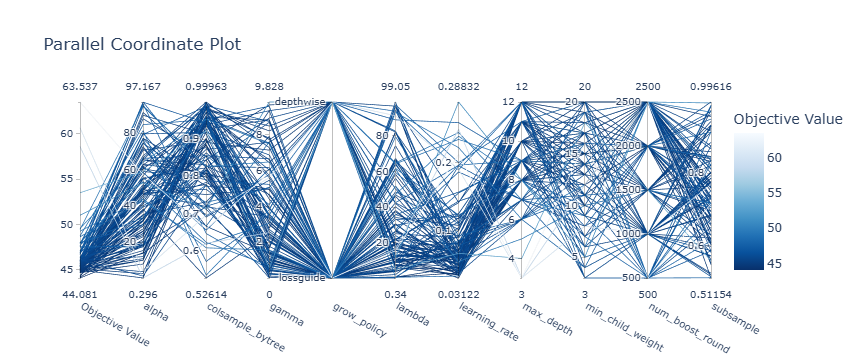

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_lvri)

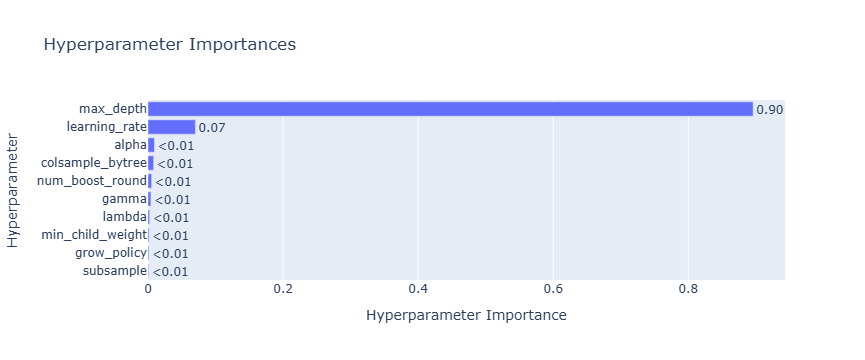

In [ ]:
optuna.visualization.plot_param_importances(study_lvri)

In [ ]:
best_params = study_lvri.best_params.copy()
num_boost_round = best_params.pop("num_boost_round")
best_params.update({"random_state": RAND})
for k, v in best_params.items():
    print(k, v)
print(num_boost_round)

learning_rate 0.03876143929687533
max_depth 10
min_child_weight 15
subsample 0.6036800627210576
colsample_bytree 0.9850053687946877
lambda 0.8860473392127588
alpha 14.228611523759795
gamma 3.526361333846049
grow_policy lossguide
random_state 10
2500


In [ ]:
optuna_train_lv_tests = [
    {
        "train": (
            start_ts,
            start_ts + pd.DateOffset(months=19 + i) - Timedelta(hours=1),
        ),
        "test": (
            start_ts + pd.DateOffset(months=19 + i),
            start_ts + pd.DateOffset(months=20 + i) - Timedelta(hours=1),
        ),
    }
    for i in range(2)
]
optuna_train_lv_tests

[{'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-03-31 23:00:00')),
  'test': (Timestamp('2023-04-01 00:00:00'),
   Timestamp('2023-04-30 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-04-30 23:00:00')),
  'test': (Timestamp('2023-05-01 00:00:00'),
   Timestamp('2023-05-31 23:00:00'))}]

In [ ]:
mae_tests = []

for split in optuna_train_lv_tests:
    X_train, y_train = drop_split(df, split["train"], FEATURES_TO_DROP)
    dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    del X_train, y_train
    
    booster = xgb.train(
        params=best_params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        verbose_eval=True,
    )
    del dtrain

    X_test, y_test = drop_split(df, split["test"], FEATURES_TO_DROP)
    dtest = xgb.DMatrix(X_test, enable_categorical=True)
    del X_test
    preds = booster.predict(dtest)
    mae_tests.append(MAE(y_test, preds))

In [ ]:
mae_tests

[71.47074890136719, 76.36345672607422]